# Data Aggregation

## Importing Essential Libraries

In [205]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import geopy.distance
import math

## Loading Data

In [206]:
maize_data_path = "../data/raw/yield_maize.tif"
soybean_data_path = "../data/raw/yield_soybean.tif"
defor_img_path = "../data/raw/10S60W.tif"

# Loading maize data
with rio.open(maize_data_path) as maize_src:
    maize_data = maize_src.read()
maize_data = np.squeeze(maize_data)

# Loading deforestation data
with rio.open(defor_img_path) as defor_src:
    defor_data = defor_src.read()
defor_data = np.squeeze(defor_data)

## Defining Data Segmentation Functions

In [207]:
def get_lat_long(data, src):
    # index array
    lat_index = np.arange(0, data.shape[0])
    long_index = np.arange(0, data.shape[1])
    
    # meshgrid
    long_grid, lat_grid = np.meshgrid(long_index, lat_index)
    
    # flattened grids
    lat_grid_flat = lat_grid.flatten()
    long_grid_flat = long_grid.flatten()
    
    # getting long and lat
    A = src.transform
    long, lat = rio.transform.xy(A, lat_grid_flat, long_grid_flat)
    
    # reshaping to shape of original data
    lat = np.array(lat).reshape(data.shape)
    long = np.array(long).reshape(data.shape)
    
    return lat, long

def segment_coords(data, lat, long, target_coords = (0, 0), length = 10):
    # latitude/longitude variables
    lat_max = target_coords[0]
    lat_min = lat_max - length
    long_min = target_coords[1]
    long_max = long_min + length
    
    # length variables
    xlen = data.shape[1]
    ylen = data.shape[0]
    
    # find xmin and xmax
    xmin, xmax = None, None
    for x in range(xlen):
        if long[0, x] > long_min:
            xmin = x if xmin == None else xmin
        if long[0, xlen - x - 1] < long_max:
            xmax = xlen - x - 1 if xmax == None else xmax
            
    # find ymin and ymax
    ymin, ymax = None, None
    for y in range(ylen):
        if lat[ylen - y - 1, 0] > lat_min:
            ymin = ylen - y - 1 if ymin == None else ymin
        if lat[y, 0] < lat_max:
            ymax = y if ymax == None else ymax
            
    # index data from top-bottom, left-right
    return data[ymax:ymin, xmin:xmax]

## Segmenting Maize Data

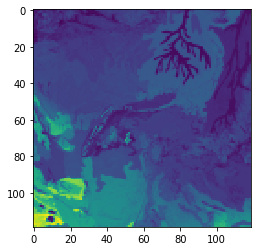

In [208]:
# Segmenting Maize Data 10S60W
target_coords = (-10, -60)
lat, long = get_lat_long(maize_data, maize_src)

maize_data_seg = segment_coords(maize_data, lat, long, target_coords, length = 10) 
plt.imshow(maize_data_seg)

## Defining Spatial Resolution Functions

In [209]:
def get_dist(coords_1, coords_2):
    return geopy.distance.distance(coords_1, coords_2).km

def get_spatial_res(dist, arr):
    return (dist / arr.shape[0])

## Compute Spatial Resolution

In [210]:
dist = get_dist((-10, -60), (-10, -50))

defor_spatial_res = get_spatial_res(dist, defor_data)
print("Defor Spatial Resolution: {} km".format(defor_spatial_res))

maize_spatial_res = get_spatial_res(dist, maize_data_seg)
print("Maize Spatial Resolution: {} km".format(maize_spatial_res))

Defor Spatial Resolution: 0.027408788864225136 km
Maize Spatial Resolution: 9.213038273689122 km


In [211]:
# 10 South, 60 West
print("Top Border Distance: {} km".format(get_dist((-10, -60), (-10, -50))))
print("Right Border Distance: {} km".format(get_dist((-10, -50), (-20, -50))))
print("Bot Border Distance: {} km".format(get_dist((-20, -60), (-20, -50))))
print("Left Border Distance: {} km".format(get_dist((-20, -60), (-10, -60))))

Top Border Distance: 1096.3515545690054 km
Right Border Distance: 1106.511420937261 km
Bot Border Distance: 1046.3150761044421 km
Left Border Distance: 1106.511420937261 km


## Computing 3km Grid

In [212]:
'''
Generates a grid where each cell represents the sum of a arr_spatial_res by cell_num_meter chunk of data.
Returns a tuple of sum grid, arr_spatial_res.
'''
def data_to_grid(arr, arr_spatial_res, grid_spatial_res = 3):
    # Initialize grid
    GRID_SIZE = math.ceil((arr.shape[0] * arr_spatial_res) / grid_spatial_res) + 1
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    # Generate grid
    for y in range(0, arr.shape[0]):
        for x in range(0, arr.shape[1]):
            # getting distance (in km) of top left corner of pixel from top left corner of entire data
            y_dist = y * arr_spatial_res
            x_dist = x * arr_spatial_res
            
            # getting indexes of grid
            grid_y = math.floor(y_dist / grid_spatial_res)
            grid_x = math.floor(x_dist / grid_spatial_res)
            
            # getting indexes of grid
            grid_y_dist = y // grid_spatial_res
            grid_x_dist = x // grid_spatial_res
            
            height_in, width_in, height_out, width_out = 0.0, 0.0, 0.0, 0.0
            
            if arr_spatial_res > grid_spatial_res:
                # compute height and width (in km) inside of grid
                height_in =  y_dist + arr_spatial_res - grid_y_dist + grid_spatial_res
                width_in =  x_dist + arr_spatial_res - grid_x_dist + grid_spatial_res
                
                # compute height and width (in km) outside of grid
                height_out = grid_spatial_res - height_in
                width_out = grid_spatial_res - width_in
            else:
                # compute height and width (in km) inside of grid
                height_in = grid_y_dist + grid_spatial_res - y_dist + arr_spatial_res
                width_in = grid_x_dist + grid_spatial_res - x_dist + arr_spatial_res
                
                # compute height and width (in km) outside of grid
                height_out = arr_spatial_res - height_in
                width_out = arr_spatial_res - width_in
                
            # update grid values
            grid[grid_y, grid_x] += width_in * height_in * arr[y, x]
            grid[grid_y + 1, grid_x] += width_in * height_out * arr[y, x]
            grid[grid_y, grid_x + 1] += width_out * height_in * arr[y, x]
            grid[grid_y + 1, grid_x + 1] += width_out * height_out * arr[y, x]
    return grid

In [213]:
def data_to_grid_smaller(arr, arr_spatial_res, grid_spatial_res = 3):
# Initialize grid
    spatial_ratio = arr_spatial_res / grid_spatial_res
    GRID_SIZE = math.ceil(arr.shape[0] * spatial_ratio)
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    # Generate grid
    for grid_y in range(0, GRID_SIZE):
        for grid_x in range(0, GRID_SIZE):
            # getting pixel indexes
            y = int(grid_y // spatial_ratio)
            x = int(grid_x // spatial_ratio)
            
            # getting distance (in km) of top left corner of pixel from top left corner of entire data
            y_dist = y * arr_spatial_res
            x_dist = x * arr_spatial_res
            
            # getting indexes of grid
            grid_y_dist = grid_y * grid_spatial_res
            grid_x_dist = grid_x * grid_spatial_res
            
            height_in, width_in, height_out, width_out = 0.0, 0.0, 0.0, 0.0
            
            # compute height and width (in km) inside of grid
            height_in = y_dist + arr_spatial_res - grid_y_dist
            height_in = arr_spatial_res if height_in < 0 else height_in
            width_in = x_dist + arr_spatial_res - grid_x_dist
            width_in = arr_spatial_res if width_in < 0 else width_in

            # compute height and width (in km) outside of grid
            height_out = arr_spatial_res - height_in
            width_out = arr_spatial_res - width_in
                
            # update grid values
            grid[grid_y, grid_x] += width_in * height_in * arr[y, x]
            if y + 1 < arr.shape[0]:
                grid[grid_y, grid_x] += width_in * height_out * arr[y + 1, x]
            if x + 1 < arr.shape[1]:
                grid[grid_y, grid_x] += width_out * height_in * arr[y, x + 1]
            if x + 1 < arr.shape[1] and y + 1 < arr.shape[0]:
                grid[grid_y, grid_x] += width_out * height_out * arr[y + 1, x + 1]
    return grid

In [229]:
def data_to_grid_smaller_updated(arr, arr_spatial_res, grid_spatial_res = 3):
# Initialize grid
    spatial_ratio = arr_spatial_res / grid_spatial_res
    GRID_SIZE = math.ceil(arr.shape[0] * spatial_ratio)
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    # Generate grid
    for grid_y in range(0, GRID_SIZE):
        for grid_x in range(0, GRID_SIZE):
            # getting pixel indexes
            y = int(grid_y // spatial_ratio)
            x = int(grid_x // spatial_ratio)
            
            # getting distance (in km) of top left corner of pixel from top left corner of entire data
            y_dist = y * arr_spatial_res
            x_dist = x * arr_spatial_res
            
            # getting indexes of grid
            grid_y_dist = grid_y * grid_spatial_res
            grid_x_dist = grid_x * grid_spatial_res
            
            height_in, width_in, height_out, width_out = 0.0, 0.0, 0.0, 0.0
            
            # compute height and width (in km) inside of grid
            height_in = min(y_dist + arr_spatial_res - grid_y_dist, grid_spatial_res)
            width_in = min(x_dist + arr_spatial_res - grid_x_dist, grid_spatial_res)

            # compute height and width (in km) outside of grid
            height_out = grid_spatial_res - height_in
            width_out = grid_spatial_res - width_in
                
            # update grid values
            grid[grid_y, grid_x] += width_in * height_in * arr[y, x]
            if y + 1 < arr.shape[0]:
                grid[grid_y, grid_x] += width_in * height_out * arr[y + 1, x]
            if x + 1 < arr.shape[1]:
                grid[grid_y, grid_x] += width_out * height_in * arr[y, x + 1]
            if x + 1 < arr.shape[1] and y + 1 < arr.shape[0]:
                grid[grid_y, grid_x] += width_out * height_out * arr[y + 1, x + 1]
    return grid

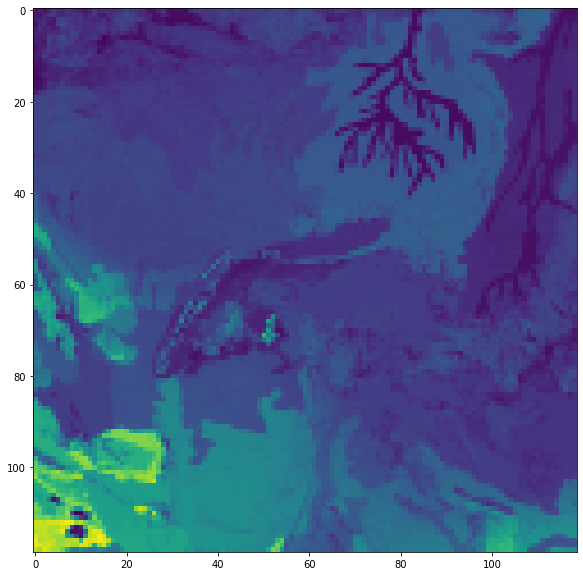

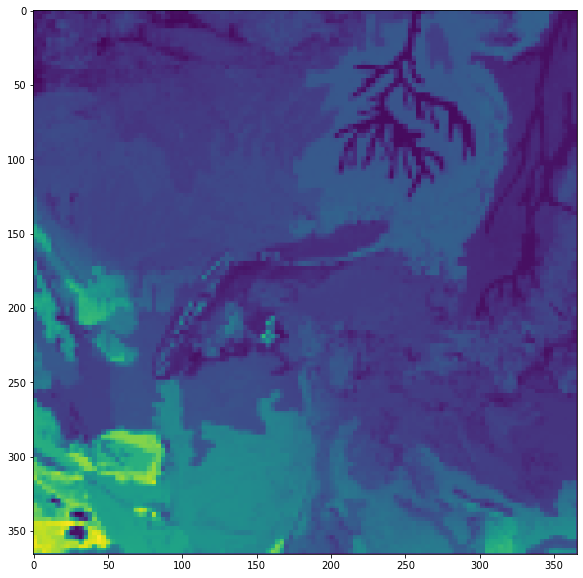

In [232]:
plt.figure(figsize = (10, 10))
plt.imshow(maize_data_seg)
plt.show()

plt.figure(figsize = (10, 10))
grid = data_to_grid_smaller_updated(maize_data_seg, maize_spatial_res)
plt.imshow(grid)
plt.show()

In [236]:
maize_data_seg[0]

array([ 461,  535,  439,  592, 1037,  804,  710, 1037,  876,  769,  584,
        526,  611, 1091,  786,  883,  824,  808,  917, 1012, 1307, 1087,
        993,  815,  793,  394,  389,  781, 1004,  422,  296,  356,  332,
        284,  879, 1045, 1127, 1053, 1056, 1147, 1219, 1255, 1240, 1055,
       1311, 1215, 1095, 1182, 1239, 1283, 1132, 1197, 1254, 1319, 1350,
       1291, 1089, 1225, 1435, 1389, 1364, 1217,  986,  838,  748,  849,
       1094, 1147, 1070,  964,  794,  772, 1163, 1233, 1185, 1128, 1185,
       1174, 1160, 1026,  968, 1002,  916,  368,  231,  881, 1244, 1100,
       1544, 1763, 1717, 1771, 1780, 1674, 1697, 1727, 1365, 1266, 1247,
       1085, 1156, 1068, 1034,  708,  639, 1201, 1875, 1954, 1970, 1940,
       1993, 1984, 1998, 1436,  839,  562,  324,  322,  325], dtype=int16)

In [235]:
(grid / 9)[0]

array([ 461.        ,  461.        ,  461.        ,  529.74505592,
        535.        ,  535.        ,  452.63444952,  439.        ,
        439.        ,  559.40514413,  592.        ,  592.        ,
        910.59729094, 1037.        , 1037.        ,  886.72986295,
        804.        ,  804.        ,  750.05119545,  710.        ,
        710.        ,  874.45179718, 1037.        , 1037.        ,
        967.46443217,  876.        ,  876.        ,  837.38528585,
        769.        ,  769.        ,  715.37360211,  584.        ,
        584.        ,  571.30613954,  526.        ,  526.        ,
        538.56698695,  611.        ,  611.        ,  647.88039073,
       1091.        , 1091.        , 1089.22447622,  786.        ,
        786.        ,  786.        ,  876.67643726,  883.        ,
        883.        ,  832.03604345,  824.        ,  824.        ,
        811.31547015,  808.        ,  808.        ,  886.67296901,
        917.        ,  917.        ,  978.821972  , 1012.     

In [225]:
maize_data_seg

array([[ 461,  535,  439, ...,  324,  322,  325],
       [ 500,  425,  753, ...,  354,  369,  321],
       [ 550,  696,  821, ...,  494,  328,  437],
       ...,
       [6140, 5564, 5699, ..., 1575, 1675, 1687],
       [6112, 5976, 5813, ..., 1671, 1682, 1676],
       [5590, 5364, 5976, ..., 3125, 3073, 2997]], dtype=int16)

In [216]:
np.unique(maize_data_seg)

array([  71,  179,  194, ..., 6214, 6222, 6312], dtype=int16)

In [217]:
data_to_grid(defor_data, defor_spatial_res)

KeyboardInterrupt: 

In [219]:
grid.min()

3998.2193268143938

In [220]:
grid.max()

533959.1705059763

In [221]:
maize_data_seg.min()

71

In [222]:
maize_data_seg.max()

6312